In [1]:
import pandas as pd
import string
import os
import itertools
import numpy as np
from sqlalchemy import create_engine, text

from app.backend.utils import DbEngine, Queries
from app.backend.etl import ETL
from app.backend.etl_sdhi import ETL_SDHI
from app.encoding_module.encoder import Encoding

In [2]:
import numpy as np
import sys

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import calinski_harabasz_score, fowlkes_mallows_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from kmodes.kmodes import KModes
from scipy.spatial import distance

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt
import seaborn as sns 
plt.style.use('seaborn')

In [3]:
pd.set_option("display.max_columns", 100)

### Connect to DB

In [4]:
db_engine = DbEngine(user = 'team77', 
                     password = 'mintic2020.',
                     ip = '172.17.0.3', 
                     port = '5432', 
                     db = 'minjusticia')
engine = db_engine.connect()
queries = Queries(engine)

### Loading original data

In [5]:
data = pd.read_excel('data/ReincidenciaPospenadosNal201011Junio2020Rev.xlsx', skiprows = 6)
data_shdi = pd.read_excel('data/SHDI Colombia 4.0.xlsx')

In [7]:
data2 = data[['INTERNOEN', 'DELITO', 'TITULO_DELITO', 'SUBTITULO_DELITO', 'TENTATIVA',
       'AGRAVADO', 'CALIFICADO', 'FECHA_INGRESO', 'FECHA_SALIDA',
       'FECHA_CAPTURA', 'SITUACION_JURIDICA', 'ANO_NACIMIENTO', 'EDAD',
       'GENERO', 'ESTADO_CIVIL', 'PAIS_INTERNO', 'DEPARTAMENTO', 'CIUDAD',
       'REINCIDENTE', 'ESTADO_INGRESO', 'ACTIVIDADES_TRABAJO',
       'ACTIVIDADES_ESTUDIO', 'ACTIVIDADES_ENSEÑANZA', 'NIVEL_EDUCATIVO',
       'HIJOS_MENORES', 'CONDIC_EXPECIONAL', 'CODIGO_ESTABLECIMIENTO',
       'ESTABLECIMIENTO', 'DEPTO_ESTABLECIMIENTO', 'MPIO_ESTABLECIMIENTO',
       'REGIONAL', 'ESTADO']]

### Execute ETL

In [ ]:
etl = ETL(queries)
etl.inmate_static_info(data2)
etl.inmate_variable_info(data2)

In [ ]:
etl_sdhi = ETL_SDHI(queries)
etl_sdhi.inmate_static_info(data_shdi)

### Functions

#### encodings

In [8]:
def encode_transform(data):
    encoders = []
    encoded_cols = []
    for i in range(data.values.shape[1]):
        le = LabelEncoder()
        le.fit(data.values[:,i])
        encoders.append(le)
        encoded_cols.append(le.transform(data.values[:,i]).reshape(-1,1))
    return np.concatenate(encoded_cols, axis = 1), encoders

#### metrics-results

In [9]:
def plot_confusion_matrix(labels, prediction, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.get_cmap('Blues')):
    """ Dibuja la matriz de confusion de los resultados de clasificacion de un modelo.
    Se puede aplicar normalizacion ajustando 'normalize=True'. """

    n = len(classes)
    if len(prediction.shape) != 1:
        matrix = multilabel_confusion_matrix(labels, prediction).reshape(n,4)
    else:
        matrix = confusion_matrix(labels, prediction)

    size = 1.4 * len(classes)
    plt.figure(figsize=(size, size))
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))

    if len(prediction.shape) != 1:
        plt.xticks(tick_marks, ['True Negatives', 'False Negatives', 'False Positives', 'True Positives'], rotation=90)
    else:
        plt.xticks(tick_marks, classes, rotation=90)

    plt.yticks(tick_marks, classes)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, matrix[i, j],
                 horizontalalignment='center',
                 color='white' if matrix[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
def classifier_results(prediction, labels, classes, show_plots):
    """ Muestra los resultados de accuracy, presenta los resultados de precision, recall y f1-score
    y genera la matriz de confusion para el conjunto de datos."""

    print('\nAccuracy:\n{0:.2f}'.format(accuracy_score(labels, prediction)))

    print(classification_report(labels, prediction, digits=2, target_names = classes))
    
    if show_plots:
        plot_confusion_matrix(labels, prediction, classes)

    return classification_report(labels, prediction, digits=2, output_dict=True)

In [11]:
def plot_roc(y_test, y_preds):
    """
    Helper function that plots the roc curve
    """
    plt.figure(figsize=(8,8))
    for label in np.unique(y_test):
        fpr, tpr, _ = roc_curve(y_test == label, y_preds == label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label= str(label) + ' AUC = ' + '{0:.2f}'.format(roc_auc))
        #plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic ROC')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def plot_precision_recall(y_test, y_preds):
    #plt.figure(figsize=(8,8))
    #for idx, label in enumerate(classes):
    #    roc_auc = auc(x[idx], y[idx])
    #    plt.plot(x[idx], y[idx], linewidth=2, label=str(label) + ': ' + 'AUC = ' + '{0:.2f}'.format(roc_auc) + ' - ' +
    #                                                               'AP = ' + '{0:.2f}'.format(ap[idx]) + ' - ' +
    #                                                               'F1 = ' + '{0:.2f}'.format(f1[idx]))
    #plt.xlim([0.0, 1.05])
    #plt.ylim([0.0, 1.05])
    #plt.xlabel('Recall')
    #plt.ylabel('Precision')
    #plt.title('Precision Recall Curve')
    #plt.legend(loc="lower right")
    #plt.grid()
    #plt.show()
    """
    Helper function that plots the roc precision recall Curve
    """
    plt.figure(figsize=(8,8))
    for label in np.unique(y_test):
        fpr, tpr, _ = precision_recall_curve(y_test == label, y_preds == label)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label= str(label) + ' AUC = ' + '{0:.2f}'.format(roc_auc))
        #plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

#### algorithms

In [13]:
##### Get closest centroid unoptimized (Prediction Strength)
def get_closest_centroid(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    min_distance = sys.float_info.max
    min_centroid = 0
    
    for c in centroids:
        dist = distance.euclidean(obs, c)
        if dist < min_distance:
            min_distance = dist
            min_centroid = c
            
    return min_centroid

In [14]:
##### Get closest centroid optimized v1 (Prediction Strength)
def get_closest_centroid_optim(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance)
    
    return centroids[idx_min_distance]

In [15]:
##### Get closest centroid optimized v2 (Prediction Strength)
def get_closest_centroid_optim_vectorized(obs, centroids):
    '''
    Function for retrieving the closest centroid to the given observation 
    in terms of the Euclidean distance.
    
    Parameters
    ----------
    obs : array
        An array containing the observation to be matched to the nearest centroid
    centroids : array
        An array containing the centroids
    
    Returns
    -------
    min_centroid : array
        The centroid closes to the obs 
    '''
    
    distance = np.sqrt((np.square(centroids[:,np.newaxis]-obs).sum(axis=2)))
    idx_min_distance = np.argmin(distance, axis = 0)
    
    return centroids[idx_min_distance]

In [16]:
##### Get prediction strength unoptimized (Prediction Strength)
def get_prediction_strength(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    n_test = len(x_test)
    
    # populate the co-membership matrix
    D = np.zeros(shape=(n_test, n_test))
    for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
        for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0
    
    # calculate the prediction strengths for each cluster
    ss = []
    for j in range(k):
        s = 0
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        for x1, l1, c1 in zip(x_test, test_labels, list(range(n_test))):
            for x2, l2, c2 in zip(x_test, test_labels, list(range(n_test))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

In [17]:
##### Get prediction strength optimized (Prediction Strength)
def get_prediction_strength_optim(k, train_centroids, x_test, test_labels):
    '''
    Function for calculating the prediction strength of clustering
    
    Parameters
    ----------
    k : int
        The number of clusters
    train_centroids : array
        Centroids from the clustering on the training set
    x_test : array
        Test set observations
    test_labels : array
        Labels predicted for the test set
        
    Returns
    -------
    prediction_strength : float
        Calculated prediction strength
    '''
    closest_cent = get_closest_centroid_optim_vectorized(x_test, train_centroids)
    
    co_membership = np.zeros((len(closest_cent), len(closest_cent)))
    for i in range(1, len(closest_cent)):
        diag = (closest_cent == np.roll(closest_cent, shift = i, axis = 0)).all(1)[i:]
        co_membership[range(i,len(closest_cent)),range(len(diag))] = diag
    co_membership = co_membership + co_membership.T - np.diag(np.diag(co_membership))
    
    # calculate the prediction strengths for each cluster
    n_test = len(x_test)
    ss = []
    for j in range(k):
        examples_j = x_test[test_labels == j, :].tolist()
        n_examples_j = len(examples_j)
        test_labels_co_mem = np.zeros((len(test_labels), len(test_labels)))
        for i in range(len(test_labels)):
            diag = (test_labels == np.roll(test_labels, shift = i)) & (test_labels == j)
            diag = diag[i:]
            test_labels_co_mem[range(i,len(test_labels)),range(len(diag))] = diag
        test_labels_co_mem = test_labels_co_mem + test_labels_co_mem.T - np.diag(np.diag(test_labels_co_mem))
        s = (co_membership * test_labels_co_mem).sum()
        ss.append(s / (n_examples_j * (n_examples_j - 1))) 

    prediction_strength = min(ss)

    return prediction_strength

### Encode

In [18]:
encoding = Encoding(queries)
data_2_encode = encoding.get_data('encoding')
data_encoded = encoding.one_hot(data_2_encode)

In [39]:
data_encoded.columns

Index(['internoen', 'genero', 'nacionalidad', 'estado_civil',
       'nivel_educativo', 'reconocimiento_etnico', 'diversidad_sexual',
       'extranjero', 'estado_ingreso', 'fecha_ingreso', 'establecimiento',
       'fecha_salida', 'edad', 'actividades_estudio', 'actividades_trabajo',
       'actividades_enseñanza', 'hijos_menores', 'condicion_excepcional',
       'estado_id_estado', 'madre_gestante', 'madre_lactante', 'discapacidad',
       'adulto_mayor', 'shdi', 'healthindex', 'incindex', 'edindex', 'lifexp',
       'gnic', 'esch', 'msch', 'pop', 'delito_CONCIERTO PARA DELINQUIR',
       'delito_EXTORSION',
       'delito_FABRICACION  TRAFICO Y PORTE DE ARMAS Y MUNICIONES DE USO PRIVATIVO DE LAS FUERZAS ARMADAS',
       'delito_FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO O MUNICIONES',
       'delito_FABRICACIÓN, TRÁFICO, PORTE O TENENCIA DE ARMAS DE FUEGO, ACCESORIOS, PARTES O MUNICIONES',
       'delito_HOMICIDIO', 'delito_HURTO', 'delito_LESIONES PERSONALES',
       'delito_OTR

#### Fixing dataset lasts issues

Evaluando cantidad de columnas vacias aún

In [20]:
data_encoded.isnull().sum().to_frame().rename(columns={0:'counts'}).sort_values(by='counts', ascending = False)

,counts
fecha_salida,30304
mean_severity,27952
max_severity,27952
pop,16513
msch,16513
esch,16513
gnic,16513
lifexp,16513
edindex,16513
incindex,16513


Evaluando qué columnas colo tienen un valor, pues de deben eliminar para el modelin

In [21]:
data_encoded.nunique().sort_values()

discapacidad                                                                                             2
delito_TRAFICO FABRICACION O PORTE DE ESTUPEFACIENTES                                                    2
delito_OTRO                                                                                              2
delito_LESIONES PERSONALES                                                                               2
delito_HURTO                                                                                             2
delito_HOMICIDIO                                                                                         2
delito_FABRICACIÓN, TRÁFICO, PORTE O TENENCIA DE ARMAS DE FUEGO, ACCESORIOS, PARTES O MUNICIONES         2
delito_FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO O MUNICIONES                                        2
delito_FABRICACION  TRAFICO Y PORTE DE ARMAS Y MUNICIONES DE USO PRIVATIVO DE LAS FUERZAS ARMADAS        2
delito_EXTORSION                     

Eliminando columnas de fechas por ahora, id de inmate y columnas con menos de 2 variables únicas

In [22]:
data = data_encoded.drop(columns = ['internoen',
                                    'fecha_ingreso',
                                    'fecha_salida'])

Creando función para llevar a cabo un encoding nuevo, dado que aún hay variables no numéricas en los datos

In [23]:
data.columns

Index(['genero', 'nacionalidad', 'estado_civil', 'nivel_educativo',
       'reconocimiento_etnico', 'diversidad_sexual', 'extranjero',
       'estado_ingreso', 'establecimiento', 'edad', 'actividades_estudio',
       'actividades_trabajo', 'actividades_enseñanza', 'hijos_menores',
       'condicion_excepcional', 'estado_id_estado', 'madre_gestante',
       'madre_lactante', 'discapacidad', 'adulto_mayor', 'shdi', 'healthindex',
       'incindex', 'edindex', 'lifexp', 'gnic', 'esch', 'msch', 'pop',
       'delito_CONCIERTO PARA DELINQUIR', 'delito_EXTORSION',
       'delito_FABRICACION  TRAFICO Y PORTE DE ARMAS Y MUNICIONES DE USO PRIVATIVO DE LAS FUERZAS ARMADAS',
       'delito_FABRICACION TRAFICO Y PORTE DE ARMAS DE FUEGO O MUNICIONES',
       'delito_FABRICACIÓN, TRÁFICO, PORTE O TENENCIA DE ARMAS DE FUEGO, ACCESORIOS, PARTES O MUNICIONES',
       'delito_HOMICIDIO', 'delito_HURTO', 'delito_LESIONES PERSONALES',
       'delito_OTRO', 'delito_TRAFICO FABRICACION O PORTE DE ESTUPEFACI

Imputing missing data from new social indices

In [24]:
social_indices_cols = ['shdi','healthindex','incindex','edindex','lifexp','gnic',
                        'esch','msch','pop','max_severity','mean_severity']

In [25]:
categorical_cols = data.columns[~data.columns.isin(social_indices_cols)]

In [26]:
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(data[social_indices_cols].values)
data_indices_imputed = imp_mean.transform(data[social_indices_cols].values)
data_indices_imputed

array([[0.74776929, 0.87074599, 0.72439067, ..., 3.24531079, 4.        ,
        4.        ],
       [0.7477636 , 0.87074796, 0.72438654, ..., 3.24108094, 1.14285714,
        1.07142857],
       [0.74776726, 0.8707473 , 0.72438845, ..., 3.23851222, 2.28571429,
        1.64285714],
       ...,
       [0.74776725, 0.87074701, 0.72438881, ..., 3.24110866, 2.62198512,
        2.28305443],
       [0.74776725, 0.87074701, 0.72438881, ..., 3.24110866, 2.62198512,
        2.28305443],
       [0.74776725, 0.87074701, 0.72438881, ..., 3.24110866, 2.62198512,
        2.28305443]])

In [27]:
data[social_indices_cols] = data_indices_imputed

In [29]:
data_enc, encoders = encode_transform(data[categorical_cols])
data_enc.shape

(103290, 34)

In [30]:
data_enc = np.concatenate((data_enc,data[social_indices_cols].values), axis = 1)
data_enc.shape

(103290, 45)

Analysing human index and se verity features

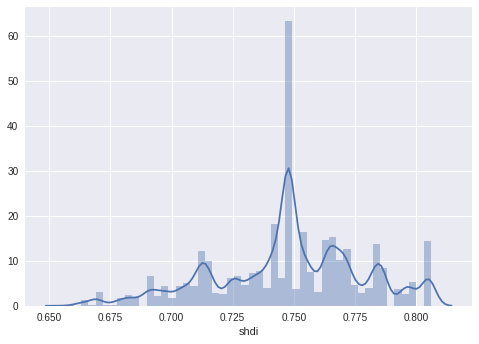

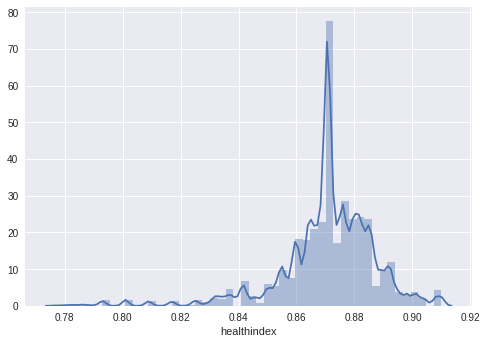

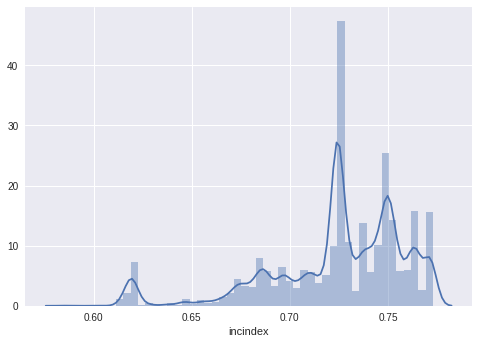

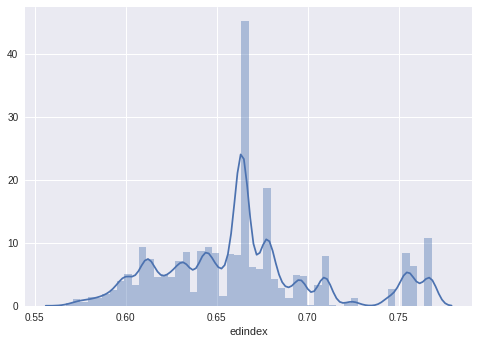

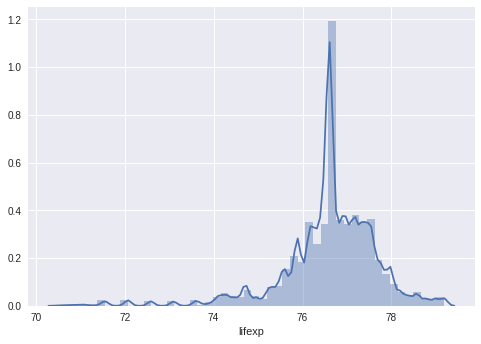

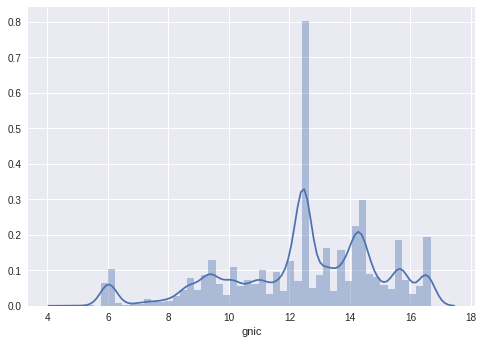

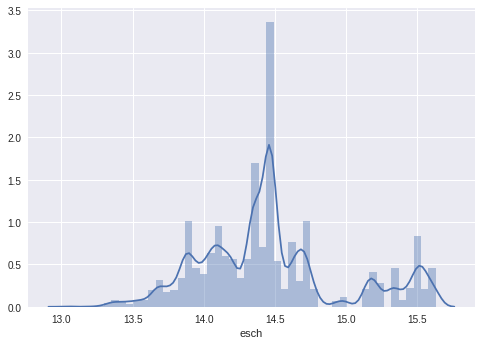

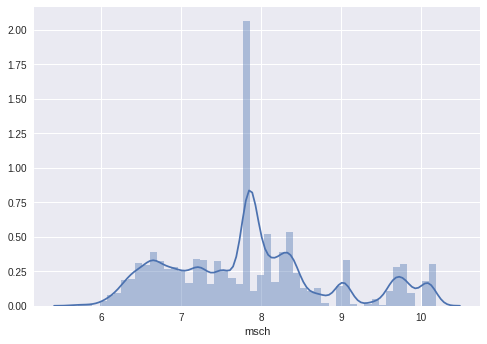

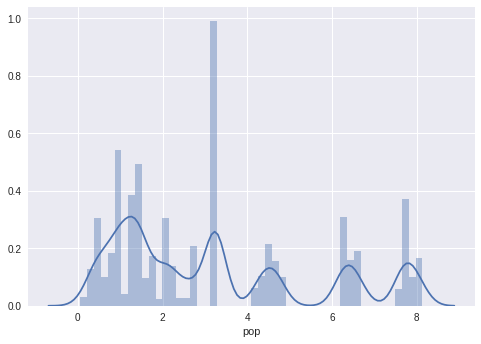

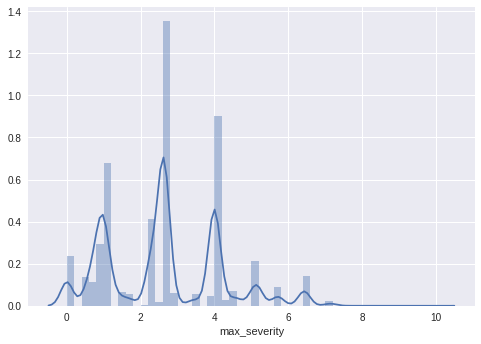

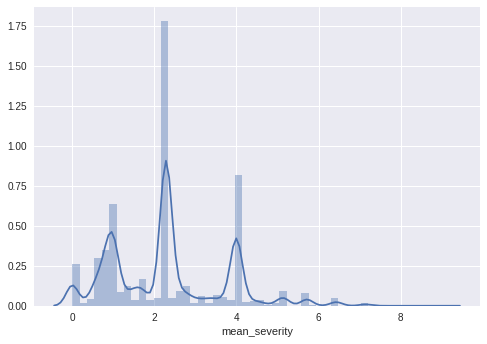

In [34]:
for i, col in enumerate(social_indices_cols):
    plt.figure()
    sns.distplot(data[social_indices_cols[i]])

### Unsupervised Learning with Kmeans

#### Elbow Plot (Within sum of squares distance)

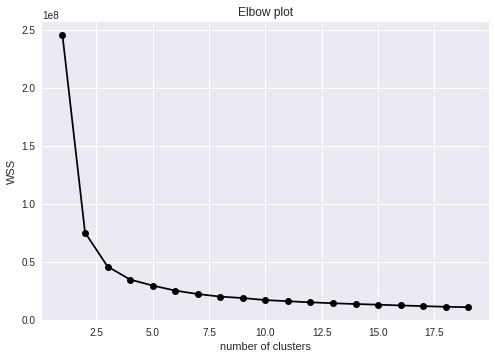

In [53]:
# setting the range of k
clusters = range(1, 20)

# running the clustering 
wss_list = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(data_enc)
    wss_list.append(model.inertia_)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

#### Prediction Strength

##### Data split

In [49]:
# train/test split
X_train, X_test = train_test_split(data_enc, 
                                   test_size=0.1, 
                                   shuffle=True, 
                                   random_state=42)

##### Running Optimized Implementation

In [51]:
# running the clustering 
strengths = []
clusters = range(2, 10)
for k in clusters:
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength_optim(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

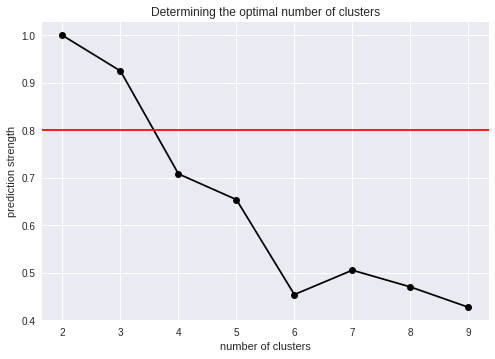

In [52]:
# plotting
### With 10% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

#### Calinski Harabaz Score

In [51]:
# setting the range of k
clusters = range(2, 20)
k_calinski_harabasz = []
for k in clusters:
    model = KMeans(n_clusters = k, random_state=42)
    model.fit(data_enc)
    
    cluster = model.predict(data_enc)
    score   = calinski_harabasz_score(data_enc, cluster)
    
    k_calinski_harabasz.append(round(score,2))

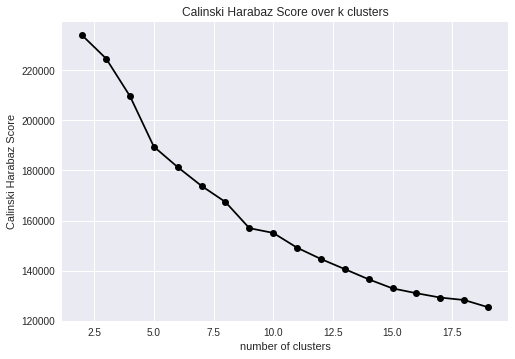

In [52]:
# plotting
_, ax = plt.subplots()
ax.plot(clusters, k_calinski_harabasz, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

#### Training Kmeans optimal Number of Clusters

In [224]:
final_kmeas = KMeans(n_clusters=4, random_state=42).fit(data_enc)
cluster_labels = final_kmeas.predict(data_enc)

#### Supervised Model to check feature importances

##### Data Spliting

FIX DATA LEAKAGE. A SINGLE INMATE CAN HAVE A SEVERAL SAMPLES, REPRESENTING EACH OF THE TIMES HE/SHE WAS ENCARCELATED. ALTHOUGH THE CRIMES CHANGE, SOME FEATURES OF THE PERSON WONT CHANGE AT ALL IN TIME. IN THE DATA SPLIT, I COULD BE ADDING RANDOMLY A PERSON IN TRAINING FOR ONE CAPTURE, AND THE SAME PERSON IN TESTING FOR ANOTHER CAPTURE. THAT IS WHY, THE TESTING RESULTS TURN OUT PRETTY MUCH EQUAL THAN IN TRAINING.

In [225]:
# train/test split
X_train, X_test, Y_train, Y_test = train_test_split(data_enc, 
                                                    cluster_labels,
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=42)

In [226]:
data_enc.shape, cluster_labels.shape

((103290, 37), (103290,))

In [227]:
pd.DataFrame(cluster_labels, columns = ['Label'])['Label'].value_counts().to_frame()

,Label
0,33693
2,29677
3,23424
1,16496


##### Logistic Regression

In [228]:
clf_logistic = LogisticRegression(random_state=42,
                         max_iter = 100, 
                         solver = 'sag',
                         class_weight = 'balanced',
                         tol = 1e-3,
                         C = 0.01).fit(X_train, Y_train)

###### Evaluating training results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23538
           1       0.99      1.00      1.00     11613
           2       1.00      1.00      1.00     20713
           3       1.00      0.99      1.00     16439

    accuracy                           1.00     72303
   macro avg       1.00      1.00      1.00     72303
weighted avg       1.00      1.00      1.00     72303



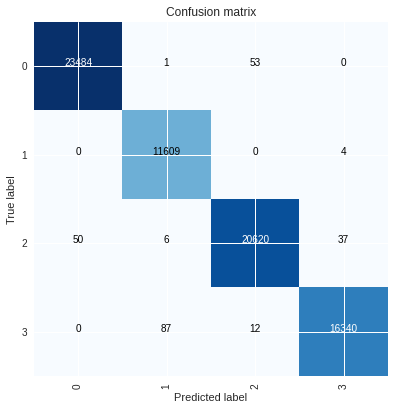

In [229]:
cr_train = classifier_results(prediction = pd.DataFrame(clf_logistic.predict(X_train))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_train)[0].astype(str).values, 
                               classes = [str(cl) for cl in clf_logistic.classes_], 
                               show_plots = True)

###### Evaluating testing results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10155
           1       0.99      1.00      1.00      4883
           2       1.00      1.00      1.00      8964
           3       1.00      0.99      1.00      6985

    accuracy                           1.00     30987
   macro avg       1.00      1.00      1.00     30987
weighted avg       1.00      1.00      1.00     30987



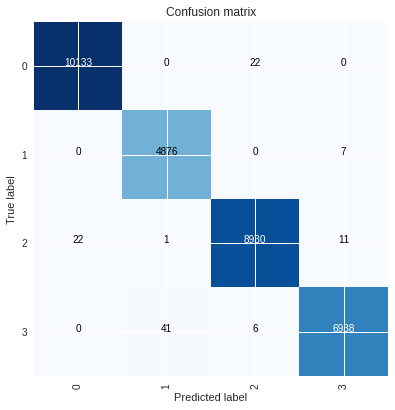

In [230]:
cr_test = classifier_results(prediction = pd.DataFrame(clf_logistic.predict(X_test))[0].astype(str).values, 
                           labels = pd.DataFrame(Y_test)[0].astype(str).values, 
                           classes = [str(cl) for cl in clf_logistic.classes_], 
                           show_plots = True)

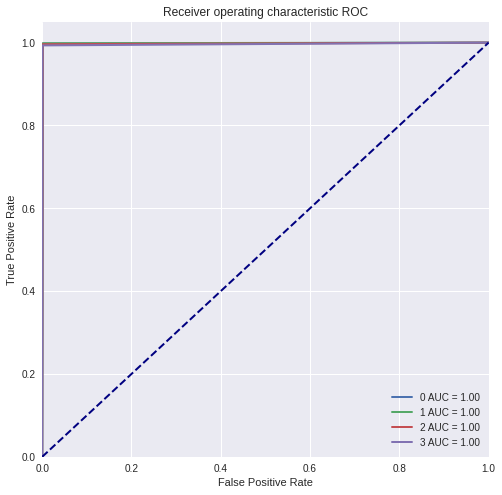

In [231]:
plot_roc(Y_test, clf_logistic.predict(X_test))

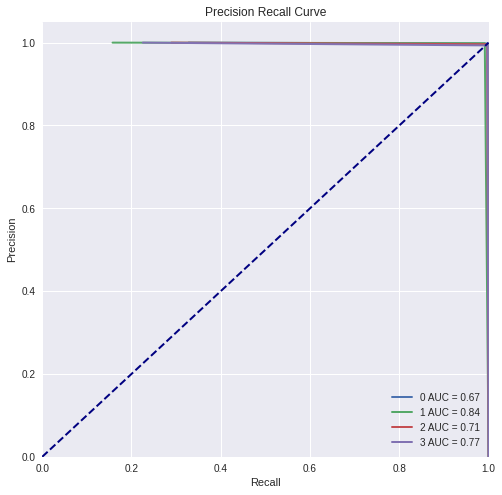

In [232]:
plot_precision_recall(Y_test, clf_logistic.predict(X_test))

###### Feature Importances

In [233]:
lg_coeffs = pd.DataFrame(clf_logistic.coef_, columns = data.columns) \
                        .T.reset_index().rename(columns = {'index':'feature'})
lg_coeffs

,feature,0,1,2,3
0,genero,0.102897,-0.121861,0.074360,-0.055396
1,nacionalidad,2.489234,-3.081846,1.190948,-0.598336
2,estado_civil,0.119735,-0.129572,0.050569,-0.040733
3,nivel_educativo,0.075550,-0.083122,0.037719,-0.030147
4,reconocimiento_etnico,0.151103,0.051227,-0.065298,-0.137031
5,diversidad_sexual,0.007991,-0.001849,-0.007755,0.001613
6,extranjero,0.006776,-0.055000,0.016932,0.031291
7,estado_ingreso,0.241487,-0.261183,0.078972,-0.059277
8,establecimiento,-1.094450,0.846167,-0.133636,0.381919
9,edad,0.023314,-0.014689,0.004731,-0.013355


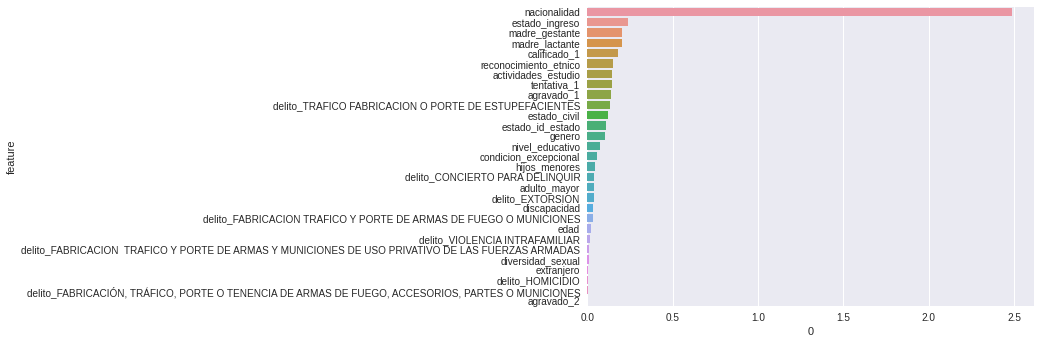

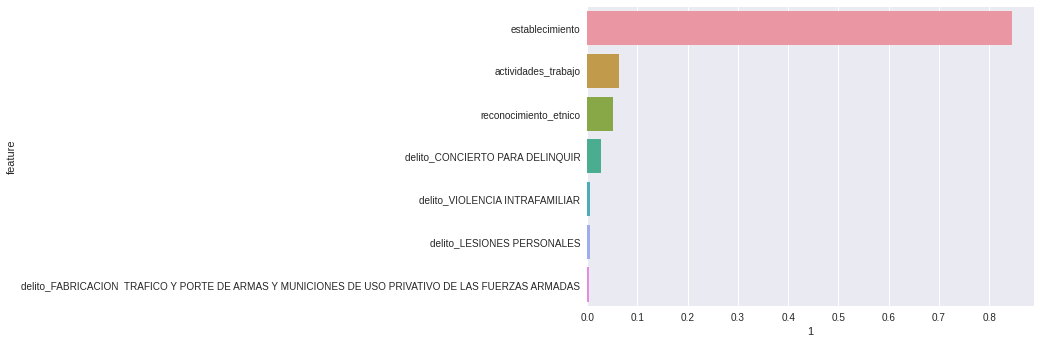

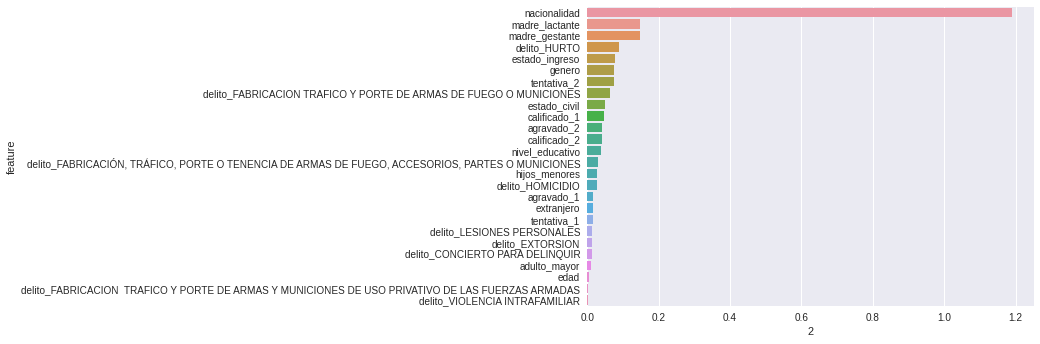

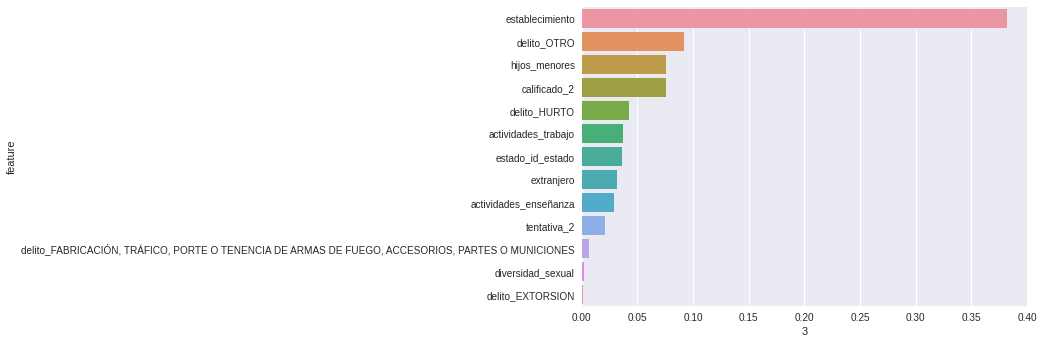

In [234]:
for i in range(4):
    d_cluster = lg_coeffs.sort_values(by=i, ascending = False)
    d_cluster = d_cluster[d_cluster[i] > 0]
    plt.figure(i)
    sns.barplot(x=i, y="feature" , data=d_cluster)

##### Random Forest Classifier

In [194]:
clf_randomf = RandomForestClassifier(random_state=42,
                                     class_weight = 'balanced',
                                     oob_score = True).fit(X_train, Y_train)

###### Evaluating training results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23538
           1       1.00      1.00      1.00     11613
           2       1.00      1.00      1.00     20713
           3       1.00      1.00      1.00     16439

    accuracy                           1.00     72303
   macro avg       1.00      1.00      1.00     72303
weighted avg       1.00      1.00      1.00     72303



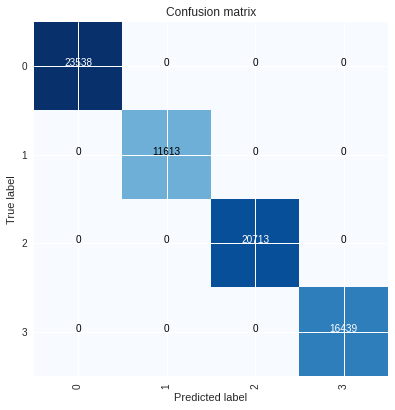

In [195]:
cr_train = classifier_results(prediction = pd.DataFrame(clf_randomf.predict(X_train))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_train)[0].astype(str).values, 
                               classes = [str(cl) for cl in clf_randomf.classes_], 
                               show_plots = True)

###### Evaluating testing results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10155
           1       1.00      1.00      1.00      4883
           2       1.00      1.00      1.00      8964
           3       1.00      1.00      1.00      6985

    accuracy                           1.00     30987
   macro avg       1.00      1.00      1.00     30987
weighted avg       1.00      1.00      1.00     30987



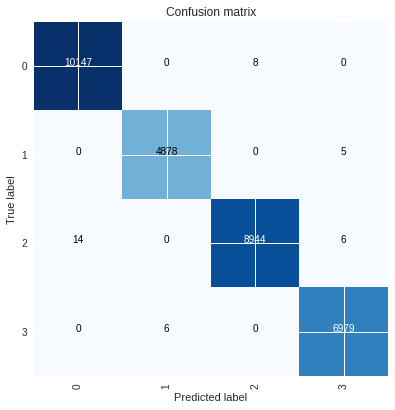

In [196]:
cr_test = classifier_results(prediction = pd.DataFrame(clf_randomf.predict(X_test))[0].astype(str).values, 
                           labels = pd.DataFrame(Y_test)[0].astype(str).values, 
                           classes = [str(cl) for cl in clf_randomf.classes_], 
                           show_plots = True)

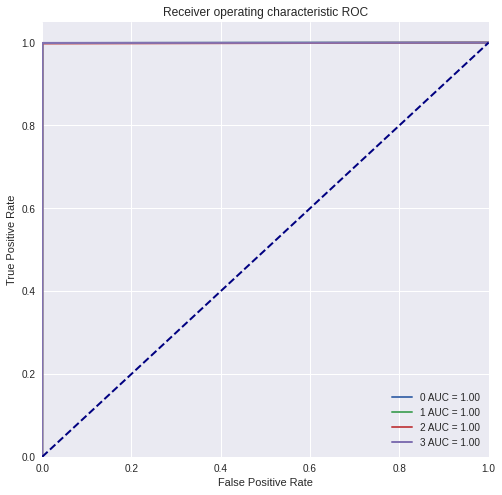

In [218]:
plot_roc(Y_test, clf_randomf.predict(X_test))

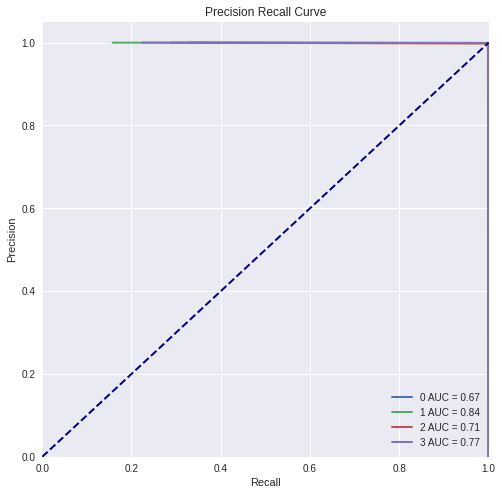

In [220]:
plot_precision_recall(Y_test, clf_randomf.predict(X_test))

###### Feature Importances

In [235]:
lg_coeffs = pd.DataFrame(clf.feature_importances_.reshape(1,-1), columns = data.columns) \
            .T.reset_index().rename(columns = {'index':'feature',
                                                0: 'feature_importance'}).sort_values(by=['feature_importance'], 
                                                                                      ascending = False)
lg_coeffs

,feature,feature_importance
8,establecimiento,0.863703
9,edad,0.026565
16,madre_gestante,0.012604
3,nivel_educativo,0.012488
0,genero,0.010739
7,estado_ingreso,0.009658
17,madre_lactante,0.007612
2,estado_civil,0.006272
10,actividades_estudio,0.003637
11,actividades_trabajo,0.003542


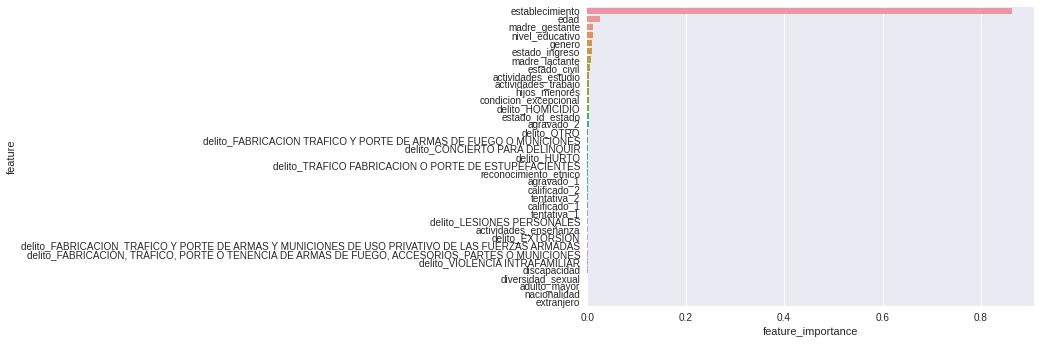

In [236]:
sns.barplot(x='feature_importance', y="feature", data=lg_coeffs)

### Unsupervised Learning with Kmodes

#### Elbow Plot (Within sum of squares distance)

(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,)
(37,

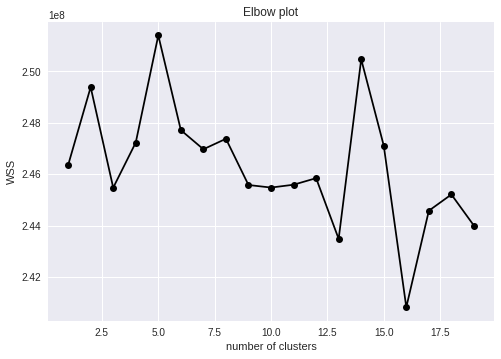

In [305]:
# setting the range of k
clusters = range(1, 20)

# running the clustering 
wss_list = []

for k in clusters:
    model = KModes(n_clusters=k, random_state=42, init='Huang')
    model.fit(data_enc)
    c_labels = model.predict(data_enc)
    wss = 0
    for k in np.unique(c_labels):
        c_idx = c_labels == k
        d_ck = data_enc[c_idx]
        center = np.median(d_ck, axis=0)
        print(center.shape)
        wss += ((d_ck - center)**2).sum(1).sum()
    wss_list.append(wss)

# plotting
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

In [ ]:
#### Prediction Strength

##### Data split

# train/test split
X_train, X_test = train_test_split(data_enc, 
                                   test_size=0.1, 
                                   shuffle=True, 
                                   random_state=42)

##### Running Optimized Implementation

# running the clustering 
strengths = []
clusters = range(2, 10)
for k in clusters:
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength_optim(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

# plotting
### With 5% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

# plotting
### With 10% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

#### Fowlkes Mallows Score

# setting the range of k
clusters = range(2, 20)
k_fowlkes_mallows = []
for k in clusters:
    model = KMeans(n_clusters = k, n_init = 100, random_state = 0)
    model.fit(data_enc)
    
    cluster = model.predict(data_enc)
    score   = fowlkes_mallows_score(data_enc, cluster)
    
    k_fowlkes_mallows.append(round(score,2))

# plotting
_, ax = plt.subplots()
ax.plot(clusters, k_fowlkes_mallows, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

#### Calinski Harabaz Score

# setting the range of k
clusters = range(2, 20)
k_calinski_harabasz = []
for k in clusters:
    model = KMeans(n_clusters = k, random_state=42)
    model.fit(data_enc)
    
    cluster = model.predict(data_enc)
    score   = calinski_harabasz_score(data_enc, cluster)
    
    k_calinski_harabasz.append(round(score,2))

# plotting
_, ax = plt.subplots()
ax.plot(clusters, k_calinski_harabasz, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

### Unsupervised Learning with GMM

#### Elbow Plot (Within sum of squares distance)

In [38]:
# setting the range of k
clusters = range(1, 15)

# running the clustering 
wss_list = []

for k in clusters:
    #gmm = GaussianMixture(n_components=k, covariance_type = 'diag', random_state=42)
    gmm = BayesianGaussianMixture(n_components=k, covariance_type = 'diag', random_state=42)
    gmm.fit(data_enc)
    c_labels = gmm.predict(data_enc)
    wss = 0
    for k in np.unique(c_labels):
        c_idx = c_labels == k
        d_ck = data_enc[c_idx]
        center = gmm.means_[k]
        wss += ((d_ck - center)**2).sum(1).sum()
    wss_list.append(wss)

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


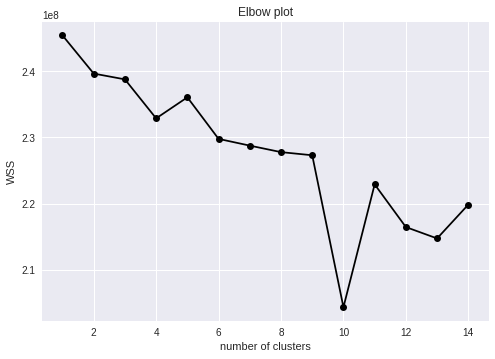

In [39]:
# plotting bgmm
_, ax = plt.subplots()
ax.plot(clusters, wss_list, '-o', color='black')
ax.set(title='Elbow plot', 
       xlabel='number of clusters', 
       ylabel='WSS');

#### Prediction Strength

##### Data split

In [36]:
# train/test split
X_train, X_test = train_test_split(data_enc, 
                                   test_size=0.1, 
                                   shuffle=True, 
                                   random_state=42)

##### Running Optimized Implementation

In [37]:
# running the clustering 
strengths = []
clusters = range(2, 10)
for k in clusters:
    model_train = BayesianGaussianMixture(n_components=k, covariance_type = 'diag', random_state=42).fit(X_train)
    model_test = BayesianGaussianMixture(n_components=k, covariance_type = 'diag', random_state=42).fit(X_test)
    
    pred_str = get_prediction_strength_optim(k, model_train.means_, X_test, model_test.predict(X_test))
    strengths.append(pred_str)

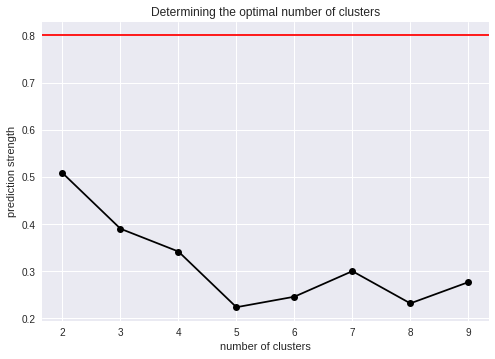

In [38]:
# plotting
### With 10% split for the testing data
_, ax = plt.subplots()
ax.plot(clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red');
ax.set(title='Determining the optimal number of clusters', 
       xlabel='number of clusters', 
       ylabel='prediction strength');

#### Calinski Harabaz Score

In [40]:
# setting the range of k
clusters = range(2, 20)
k_calinski_harabasz = []
for k in clusters:
    #model = GaussianMixture(n_components=k, covariance_type = 'diag', random_state=42)
    model = BayesianGaussianMixture(n_components=k, covariance_type = 'diag', random_state=42)
    model.fit(data_enc)
    
    cluster = model.predict(data_enc)
    score   = calinski_harabasz_score(data_enc, cluster)
    
    k_calinski_harabasz.append(round(score,2))

/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


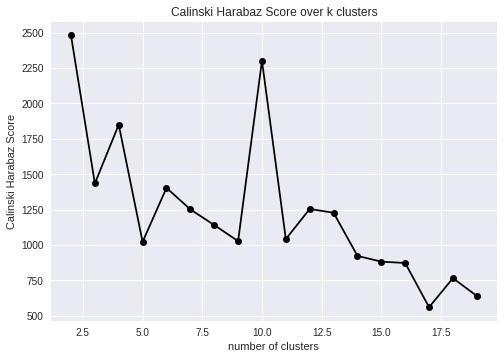

In [42]:
# plotting bgmm
_, ax = plt.subplots()
ax.plot(clusters, k_calinski_harabasz, '-o', color='black')
ax.set(title='Calinski Harabaz Score over k clusters', 
       xlabel='number of clusters', 
       ylabel='Calinski Harabaz Score');

#### Training GMM optimal Number of Clusters

In [54]:
final_bgmm = BayesianGaussianMixture(n_components=10, covariance_type = 'diag', random_state=42).fit(data_enc)
cluster_labels = final_bgmm.predict(data_enc)

#### Supervised Model to check feature importances

##### Data Spliting

In [55]:
unique_indices = data_encoded[['internoen','fecha_ingreso']]
unique_inmate = unique_indices['internoen'].unique()
unique_inmate

array(['7B848D0D3891217532241500FCCC7B861717DEEF',
       '75DD02795236128C646966C291B41828E1F6053A',
       '161C61CFC8A9A718985EA60D18BF88BA5920C238', ...,
       'AC0C4A8D9B4EF8D0037363902F076DF17F455696',
       '0BCDF3411232AD5EF4BD944791BC4C363460D4D6',
       '47954A4674E6123B392E3E4B3E1A4415AF5A9088'], dtype=object)

In [56]:
inmate_train, inmate_test = train_test_split(unique_inmate, 
                                             test_size=0.3, 
                                             shuffle=True, 
                                             random_state=42)

In [57]:
index_train = unique_indices[unique_indices['internoen'].isin(inmate_train)].index.values
index_test = unique_indices[unique_indices['internoen'].isin(inmate_test)].index.values

In [58]:
# train/test split
X_train = data_enc[index_train]
X_test = data_enc[index_test]
Y_train = cluster_labels[index_train]
Y_test = cluster_labels[index_test]

In [59]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((72276, 45), (31014, 45), (72276,), (31014,))

In [60]:
pd.DataFrame(cluster_labels, columns = ['Label'])['Label'].value_counts().to_frame()

,Label
2,66077
3,12087
0,5936
6,5208
9,4484
4,4034
7,2768
1,1970
5,392
8,334


##### Logistic Regression

In [75]:
clf_logistic = LogisticRegression(
                                  random_state=42,
                                  max_iter = 1000, 
                                  solver = 'sag',
                                  class_weight = 'balanced',
                                  tol = 1e-3,
                                  C = 0.1
                                 ).fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


###### Evaluating training results


Accuracy:
0.90
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      4217
           1       0.90      0.99      0.95      1350
           2       1.00      0.87      0.93     46272
           3       0.92      0.94      0.93      8436
           4       0.37      0.97      0.54      2784
           5       0.25      0.92      0.40       276
           6       0.99      0.88      0.93      3598
           7       0.94      0.95      0.95      1931
           8       1.00      0.65      0.79       232
           9       0.74      0.99      0.85      3180

    accuracy                           0.90     72276
   macro avg       0.81      0.91      0.82     72276
weighted avg       0.95      0.90      0.91     72276



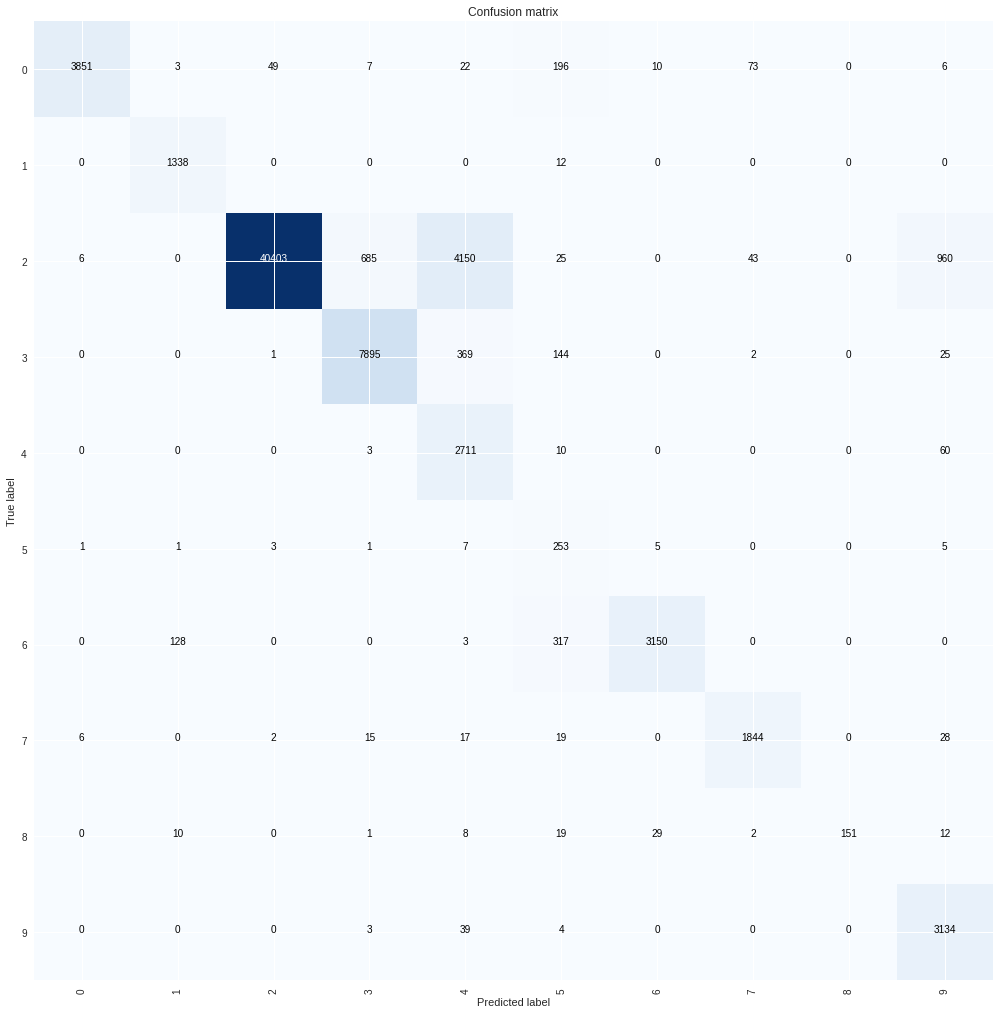

In [76]:
cr_lr_train = classifier_results(prediction = pd.DataFrame(clf_logistic.predict(X_train))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_train)[0].astype(str).values, 
                               classes = [str(cl) for cl in clf_logistic.classes_], 
                               show_plots = True)

###### Evaluating testing results


Accuracy:
0.90
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1719
           1       0.92      0.99      0.96       620
           2       1.00      0.87      0.93     19805
           3       0.93      0.94      0.93      3651
           4       0.39      0.98      0.55      1250
           5       0.24      0.86      0.37       116
           6       0.98      0.87      0.92      1610
           7       0.94      0.96      0.95       837
           8       0.98      0.62      0.76       102
           9       0.74      0.99      0.84      1304

    accuracy                           0.90     31014
   macro avg       0.81      0.90      0.82     31014
weighted avg       0.95      0.90      0.91     31014



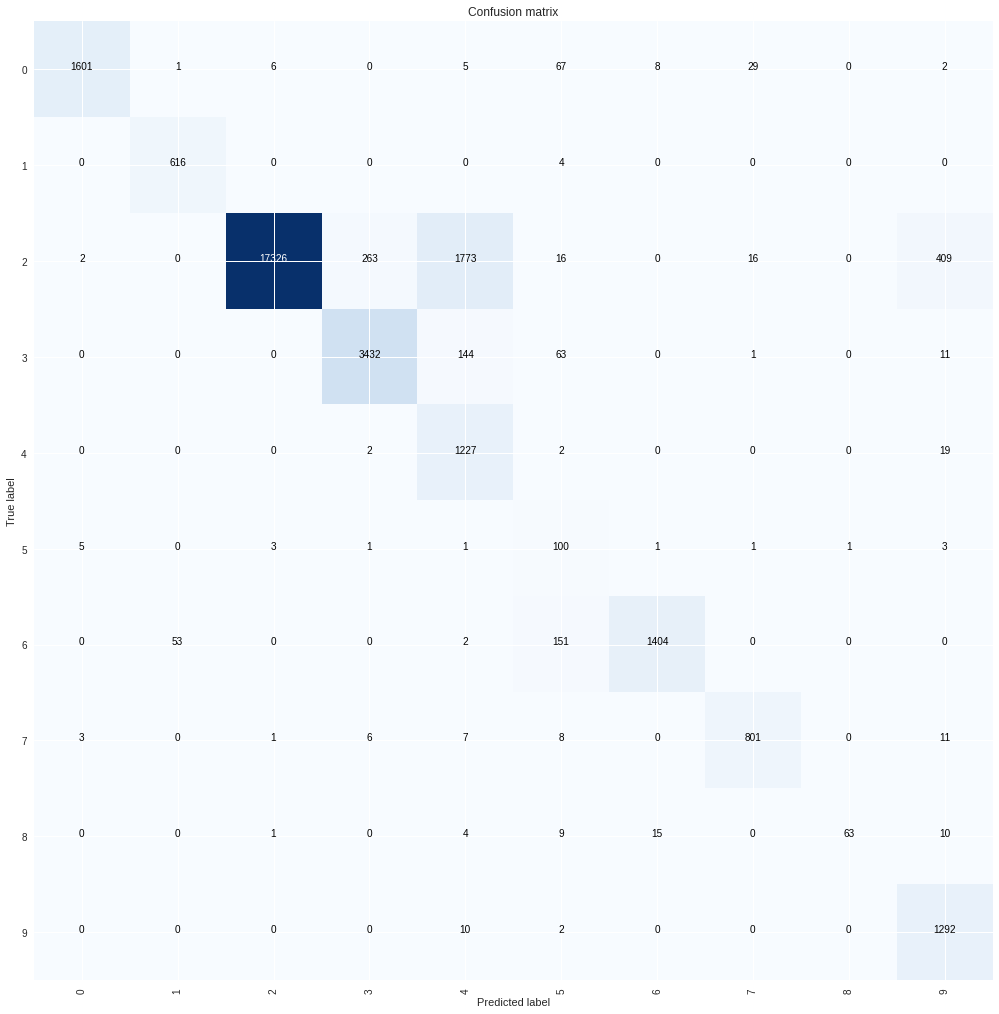

In [77]:
cr_lr_test = classifier_results(prediction = pd.DataFrame(clf_logistic.predict(X_test))[0].astype(str).values, 
                           labels = pd.DataFrame(Y_test)[0].astype(str).values, 
                           classes = [str(cl) for cl in clf_logistic.classes_], 
                           show_plots = True)

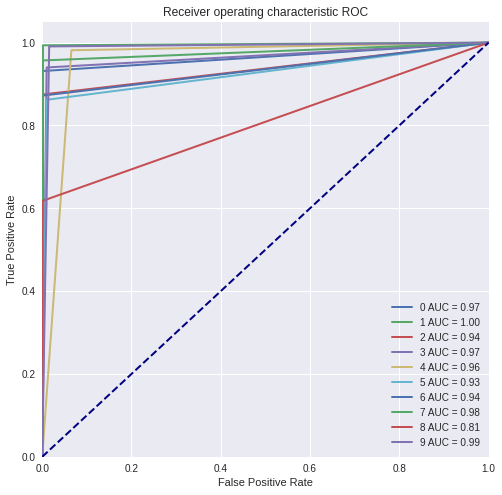

In [80]:
plot_roc(Y_test, clf_logistic.predict(X_test))

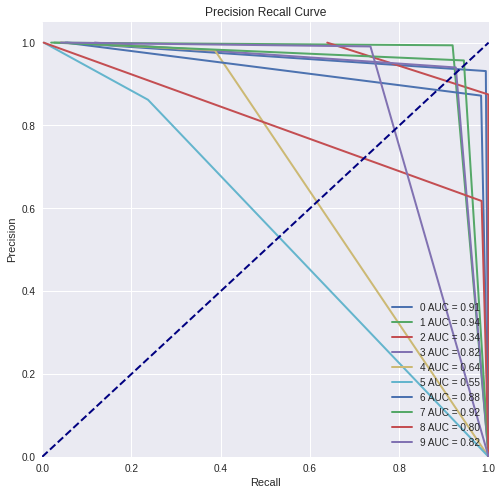

In [81]:
plot_precision_recall(Y_test, clf_logistic.predict(X_test))

###### Feature Importances

In [82]:
lg_coeffs = pd.DataFrame(clf_logistic.coef_, columns = data.columns) \
                        .T.reset_index().rename(columns = {'index':'feature'})
lg_coeffs

,feature,0,1,2,3,4,5,6,7,8,9
0,genero,0.835333,-7.531095,4.466406,4.099621,4.215586,-1.771795,-8.825969,5.238346,-5.847048,5.120614
1,nacionalidad,0.362614,-3.425467,0.815714,-0.249553,4.302015,-2.504056,-0.909173,-0.282114,-0.171733,2.061753
2,estado_civil,0.047072,-0.605662,0.366559,0.417843,0.420804,-0.008936,-0.339019,0.045492,-0.617467,0.273314
3,nivel_educativo,-0.151329,-0.614964,-0.122560,0.036492,-0.029307,0.276738,-0.190773,0.244071,0.286529,0.265103
4,reconocimiento_etnico,-8.652027,-0.726410,5.548950,4.003153,3.454049,-4.954358,6.169836,-9.379777,1.101191,3.435392
5,diversidad_sexual,14.850997,-3.104658,-9.138737,-9.192014,-9.246746,21.619771,14.834746,-11.707016,-3.241024,-5.675319
6,extranjero,-16.858487,-0.051788,-3.274531,-1.225070,-0.009927,33.942783,-1.404408,-10.776893,-0.034427,-0.307252
7,estado_ingreso,0.273132,-0.338665,0.067961,0.291047,0.303667,-1.121572,-0.300745,0.871694,-0.199545,0.153027
8,establecimiento,0.002179,-0.952020,0.139604,0.106897,0.155948,-0.168758,0.679358,-0.065542,-0.024303,0.126638
9,edad,0.061748,0.061858,-0.037151,0.034946,-0.039503,-0.042924,-0.175550,0.121304,-0.009245,0.024515


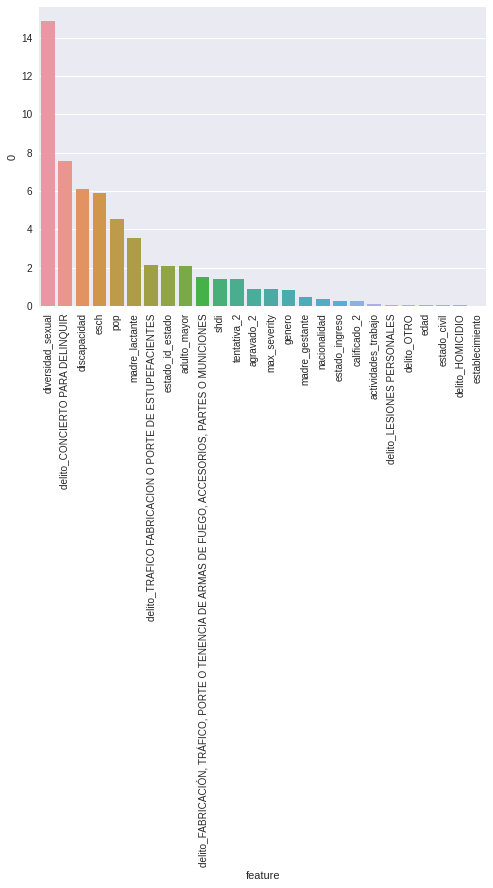

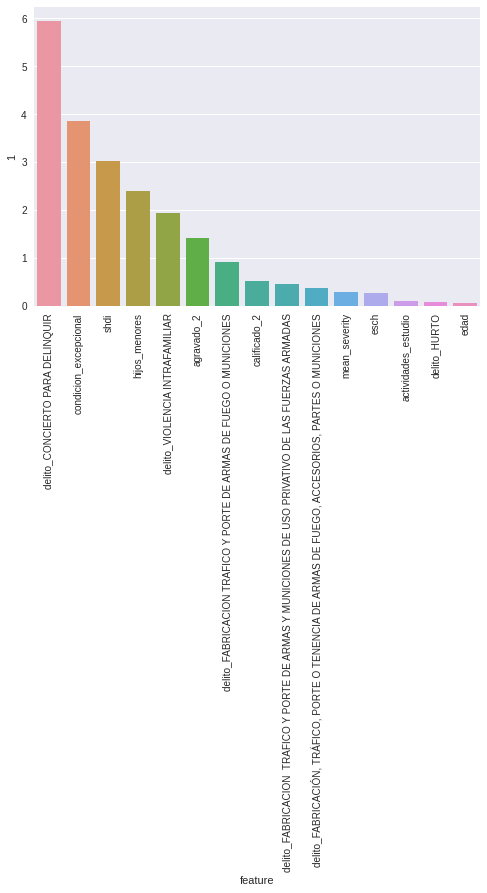

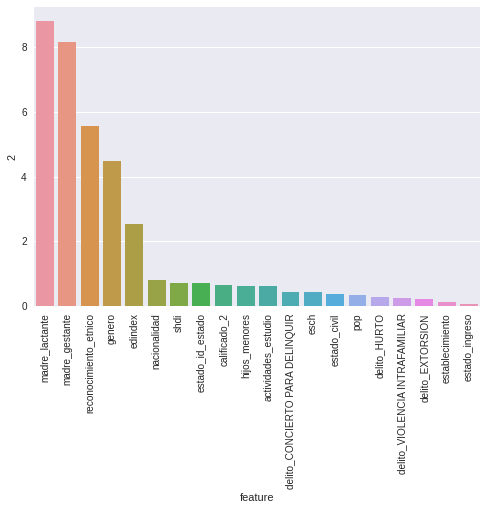

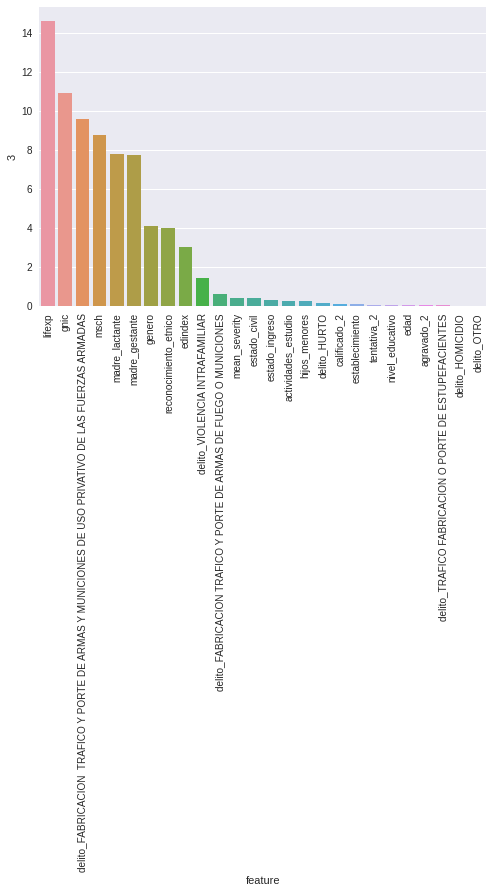

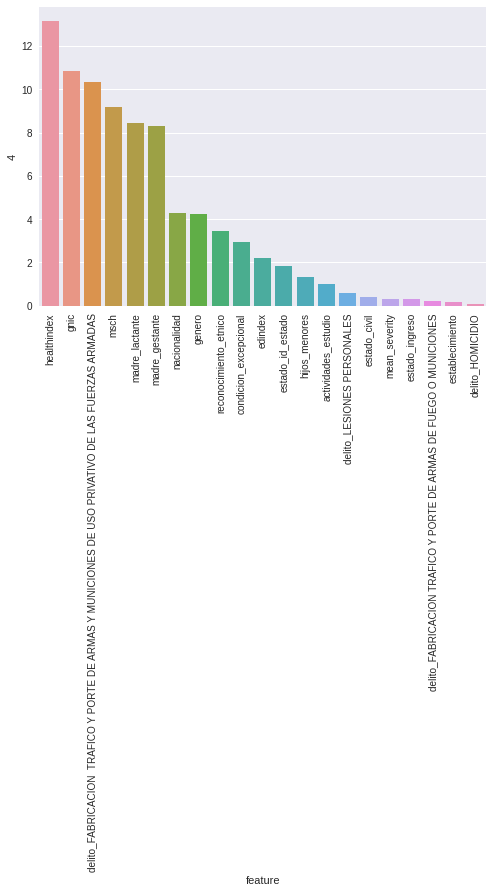

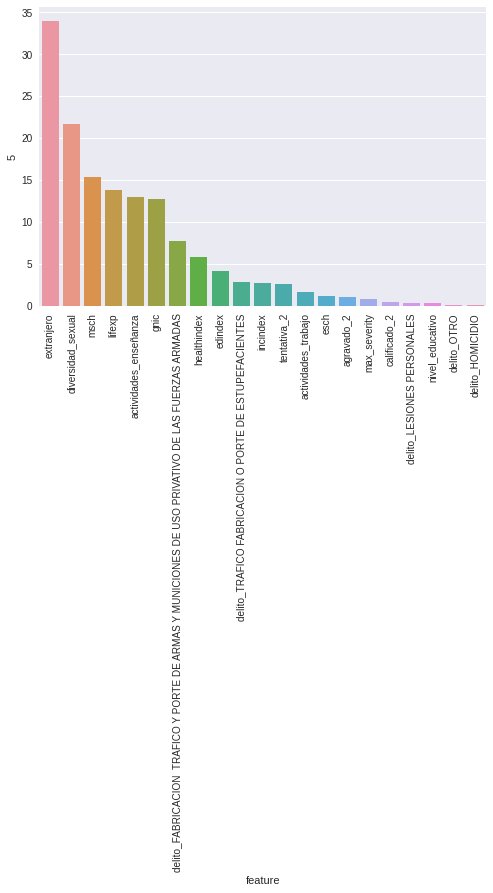

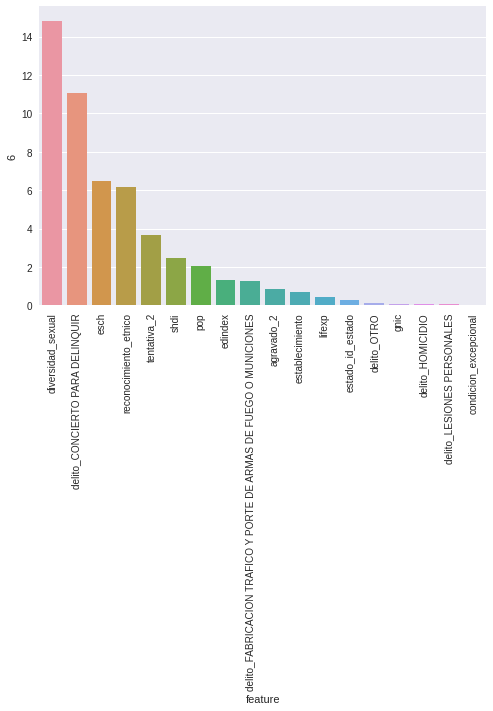

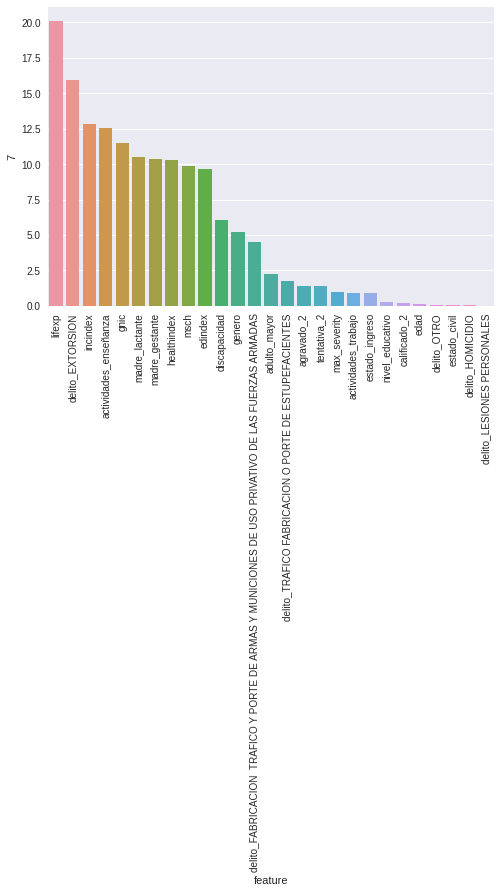

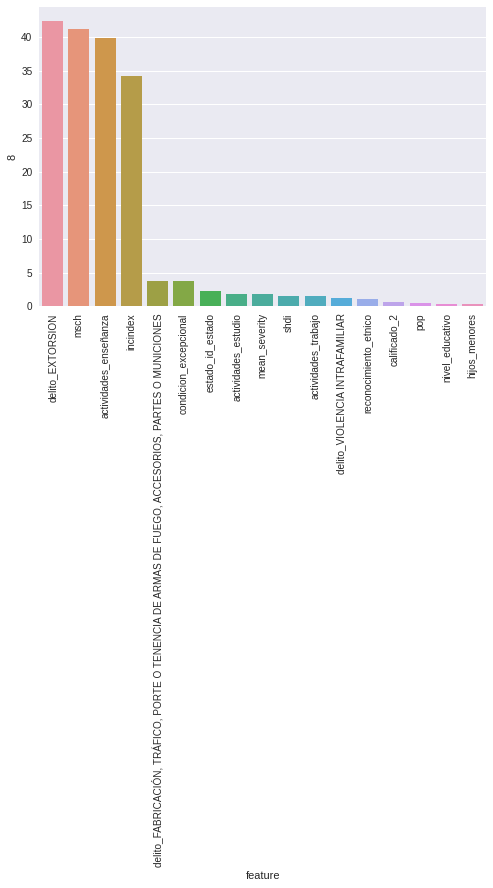

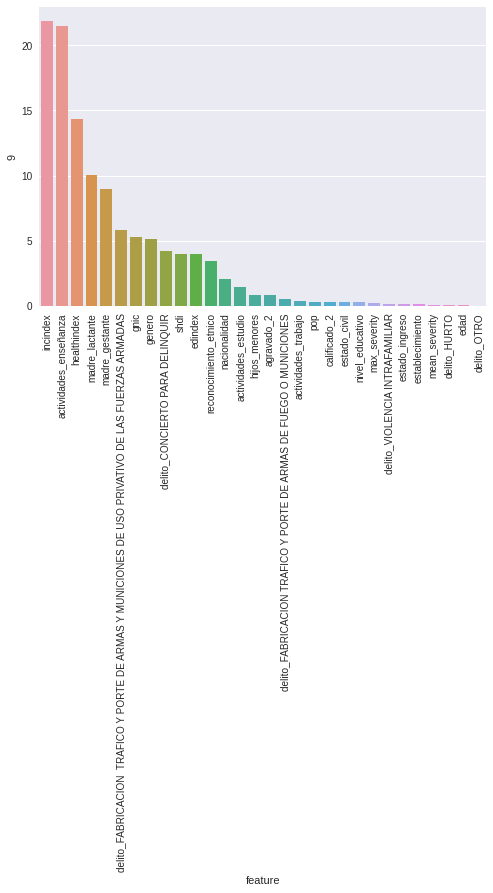

In [83]:
for i in clf_logistic.classes_:
    d_cluster = lg_coeffs.sort_values(by=i, ascending = False)
    d_cluster = d_cluster[d_cluster[i] > 0]
    plt.figure(i)
    sns.barplot(x="feature", y=i , data=d_cluster)
    plt.xticks(rotation=90)

##### Random Forest Classifier

In [68]:
clf_randomf = RandomForestClassifier(random_state=42,
                                     class_weight = 'balanced',
                                     oob_score = True).fit(X_train, Y_train)

###### Evaluating training results


Accuracy:
1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4217
           1       1.00      1.00      1.00      1350
           2       1.00      1.00      1.00     46272
           3       1.00      1.00      1.00      8436
           4       1.00      1.00      1.00      2784
           5       1.00      1.00      1.00       276
           6       1.00      1.00      1.00      3598
           7       1.00      1.00      1.00      1931
           8       1.00      1.00      1.00       232
           9       1.00      1.00      1.00      3180

    accuracy                           1.00     72276
   macro avg       1.00      1.00      1.00     72276
weighted avg       1.00      1.00      1.00     72276



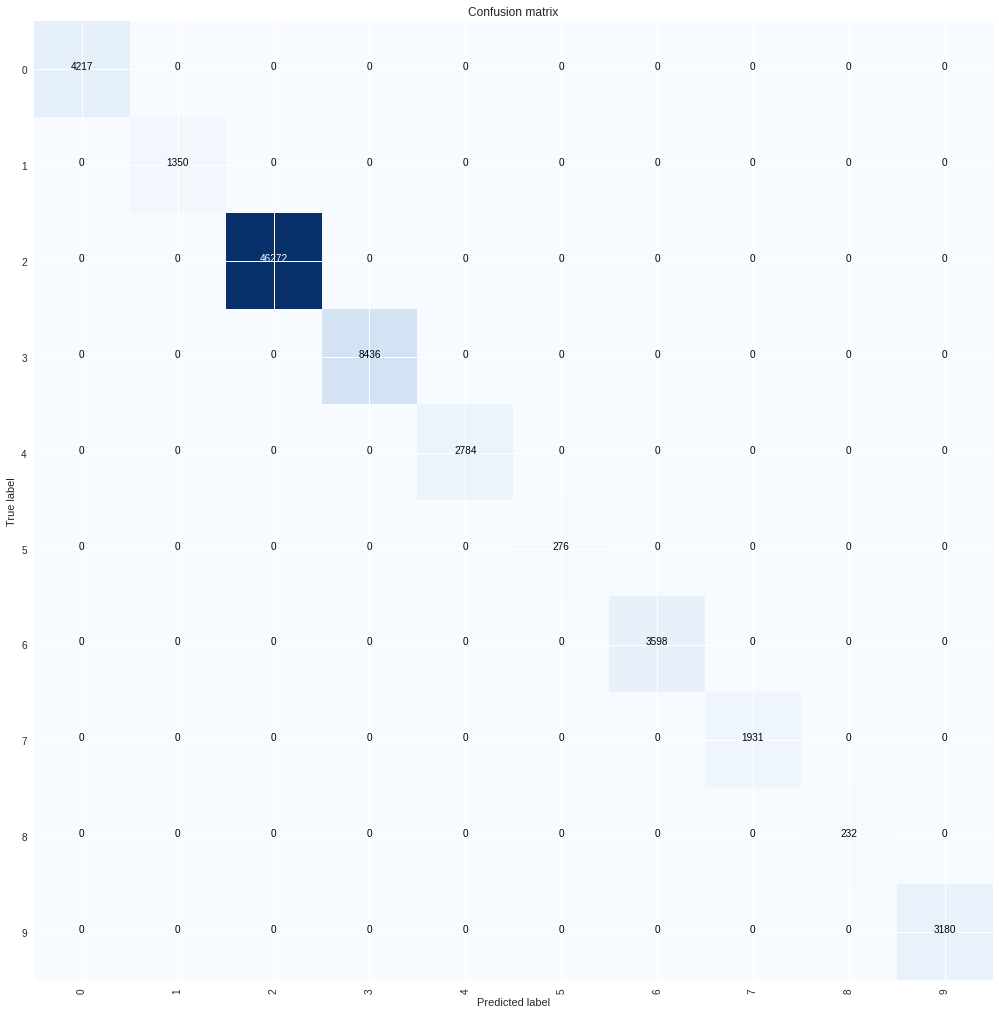

In [69]:
cr_rf_train = classifier_results(prediction = pd.DataFrame(clf_randomf.predict(X_train))[0].astype(str).values, 
                               labels = pd.DataFrame(Y_train)[0].astype(str).values, 
                               classes = [str(cl) for cl in clf_randomf.classes_], 
                               show_plots = True)

###### Evaluating testing results


Accuracy:
0.99
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1719
           1       0.98      1.00      0.99       620
           2       1.00      1.00      1.00     19805
           3       0.99      0.99      0.99      3651
           4       0.97      0.97      0.97      1250
           5       0.96      0.46      0.62       116
           6       0.98      1.00      0.99      1610
           7       0.99      0.94      0.96       837
           8       0.98      0.64      0.77       102
           9       0.97      0.99      0.98      1304

    accuracy                           0.99     31014
   macro avg       0.98      0.90      0.93     31014
weighted avg       0.99      0.99      0.99     31014



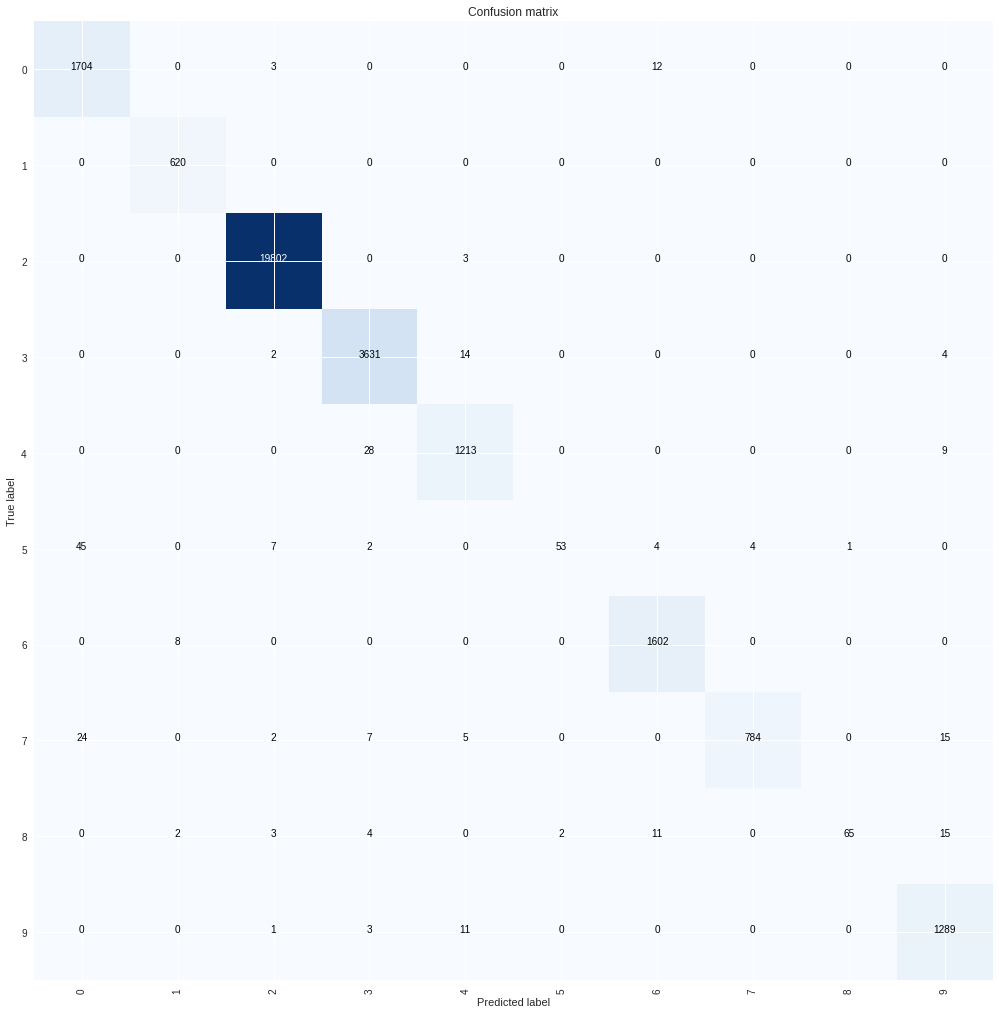

In [70]:
cr_rf_test = classifier_results(prediction = pd.DataFrame(clf_randomf.predict(X_test))[0].astype(str).values, 
                           labels = pd.DataFrame(Y_test)[0].astype(str).values, 
                           classes = [str(cl) for cl in clf_randomf.classes_], 
                           show_plots = True)

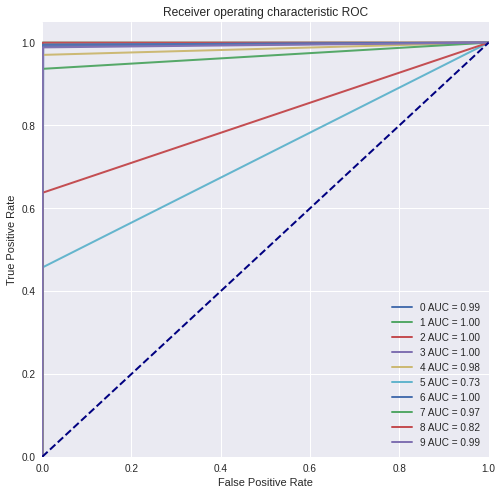

In [71]:
plot_roc(Y_test, clf_randomf.predict(X_test))

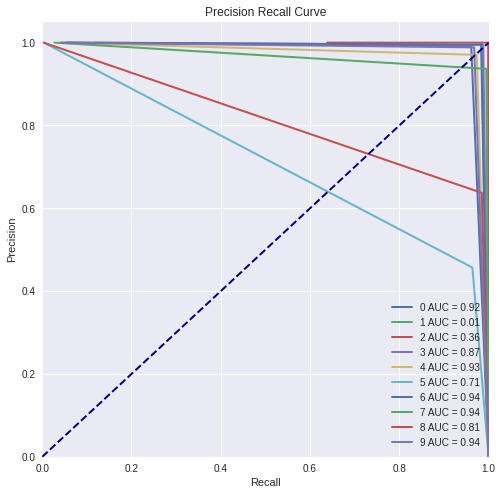

In [72]:
plot_precision_recall(Y_test, clf_randomf.predict(X_test))

###### Feature Importances

In [73]:
lg_coeffs = pd.DataFrame(clf_randomf.feature_importances_.reshape(1,-1), columns = data.columns) \
            .T.reset_index().rename(columns = {'index':'feature',
                                                0: 'feature_importance'}).sort_values(by=['feature_importance'], 
                                                                                      ascending = False)
lg_coeffs

,feature,feature_importance
14,condicion_excepcional,0.108805
8,establecimiento,0.063185
12,actividades_enseñanza,0.053070
22,incindex,0.043842
27,msch,0.042319
25,gnic,0.041420
31,delito_FABRICACION TRAFICO Y PORTE DE ARMAS Y...,0.039340
16,madre_gestante,0.035308
17,madre_lactante,0.034980
21,healthindex,0.034538


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 <a list of 45 Text major ticklabel objects>)

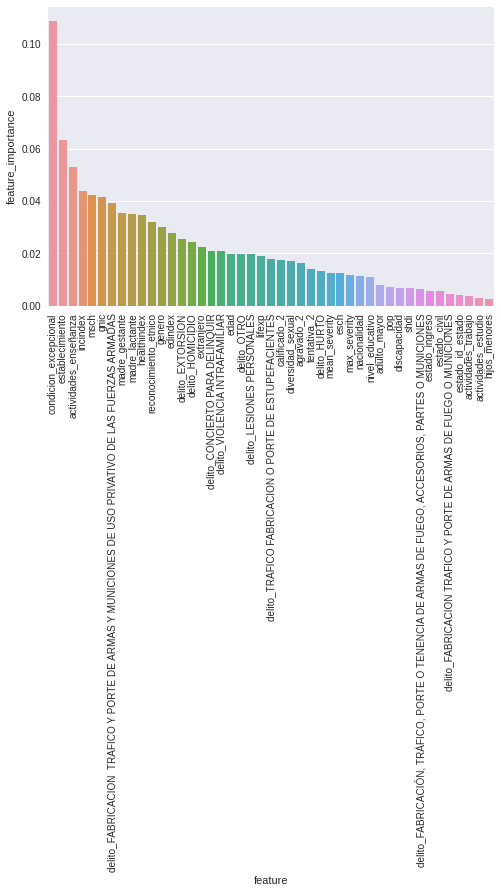

In [74]:
plt.figure()
sns.barplot(x='feature', y="feature_importance", data=lg_coeffs)
plt.xticks(rotation=90)